NB : This is pure coding notebook. Markdowns are only written for the justification

In [26]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from tqdm import tqdm
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, when, col
from pyspark.ml.feature import VectorAssembler, StandardScaler

from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [27]:
spark = SparkSession.builder.appName("challenge on employees performance").getOrCreate()

In [28]:
data = (
    spark.read.format("csv")
    .option("inferSchema", True)
    .option("header", True)
    .load("../data/challenge_dataset.csv")
)

data.show(5)

+----------+------------------+-------------------+-------------------+-------------------+---------------+
|EmployeeID|              KPI1|               KPI2|               KPI3|               KPI4|CurrentEmployee|
+----------+------------------+-------------------+-------------------+-------------------+---------------+
|         0|1.4347155493478079| 0.8445778971189396| 1.2907117554310856|-1.4201273531837943|              1|
|         1|0.8916245735832885| 0.8308158727699302| 1.0779750584283363|-1.0598957663940176|              1|
|         2|-0.891158353098296|-0.9469681237741348|-1.1825287909456643| 1.1269205082112577|              0|
|         3|1.2797294893867808| 1.6690888870054317| 1.9769417044649022| -1.797525912345404|              1|
|         4|0.2576789316661615|0.34201906896710577|0.40342208520171396|-0.3653830886145554|              1|
+----------+------------------+-------------------+-------------------+-------------------+---------------+
only showing top 5 rows


In [29]:
data.printSchema()

root
 |-- EmployeeID: integer (nullable = true)
 |-- KPI1: double (nullable = true)
 |-- KPI2: double (nullable = true)
 |-- KPI3: double (nullable = true)
 |-- KPI4: double (nullable = true)
 |-- CurrentEmployee: integer (nullable = true)



In [30]:
_ = f"Rows : {data.count()}, columns : {len(data.columns)}"
_

'Rows : 4000, columns : 6'

In [31]:
feature_columns = [col for col, typ in data.dtypes if typ == "double"]

feature_set = data.select(feature_columns).toPandas()
feature_set.head()

,KPI1,KPI2,KPI3,KPI4
0,1.434716,0.844578,1.290712,-1.420127
1,0.891625,0.830816,1.077975,-1.059896
2,-0.891158,-0.946968,-1.182529,1.126921
3,1.279729,1.669089,1.976942,-1.797526
4,0.257679,0.342019,0.403422,-0.365383


array([[<Axes: title={'center': 'KPI1'}>,
        <Axes: title={'center': 'KPI2'}>],
       [<Axes: title={'center': 'KPI3'}>,
        <Axes: title={'center': 'KPI4'}>]], dtype=object)

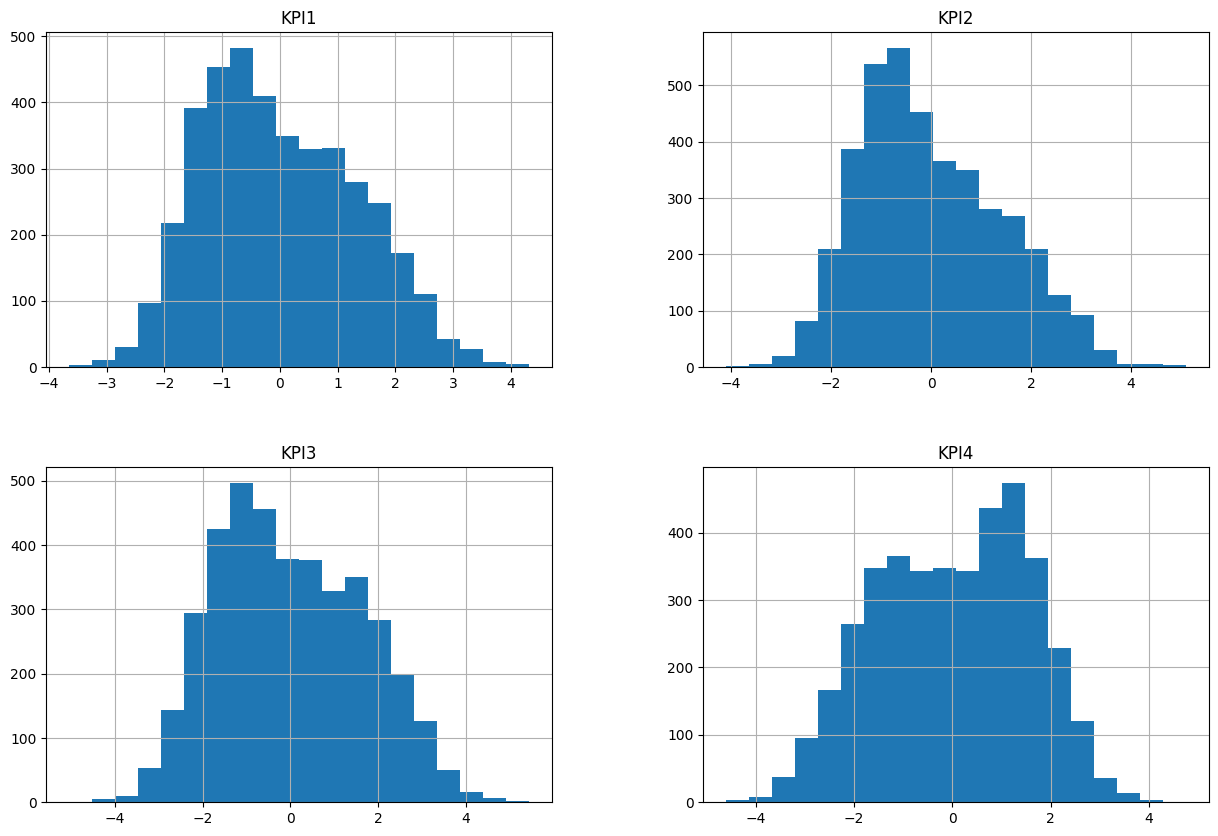

In [32]:
fig = plt.figure(figsize=(15, 10))
ax = fig.gca()
feature_set.hist(ax=ax, bins=20)

In [33]:
feature_set.corr()

,KPI1,KPI2,KPI3,KPI4
KPI1,1.000000,0.700813,0.835371,-0.925955
KPI2,0.700813,1.000000,0.977555,-0.918305
KPI3,0.835371,0.977555,1.000000,-0.981096
KPI4,-0.925955,-0.918305,-0.981096,1.000000


In [34]:
for column in feature_columns:
    data.select(count(when(col(column).isNull(), column)).alias(column)).show()

+----+
|KPI1|
+----+
|   0|
+----+

+----+
|KPI2|
+----+
|   0|
+----+

+----+
|KPI3|
+----+
|   0|
+----+

+----+
|KPI4|
+----+
|   0|
+----+



No need to impute for missing values, nor removing outliers

In [35]:
vector_assembler = VectorAssembler(
    inputCols=feature_columns, outputCol="input_features"
)

data = vector_assembler.transform(data)

scaler = StandardScaler(
    inputCol="input_features",
    outputCol="input_features_scaled",
    withMean=True,
    withStd=True,
)

data = scaler.fit(data).transform(data)

In [37]:
# Filtering the columns

ml_ready_data = data.select(
    ["input_features", "input_features_scaled", "CurrentEmployee"]
)
ml_ready_data = ml_ready_data.selectExpr(
    "input_features as input_features",
    "input_features_scaled as input_features_scaled",
    "CurrentEmployee as true",
)
ml_ready_data.show(5)

+--------------------+---------------------+----+
|      input_features|input_features_scaled|true|
+--------------------+---------------------+----+
|[1.43471554934780...| [1.08218890600599...|   1|
|[0.89162457358328...| [0.67319507945975...|   1|
|[-0.8911583530982...| [-0.6693925230286...|   0|
|[1.27972948938678...| [0.96547118364731...|   1|
|[0.25767893166616...| [0.19577994004412...|   1|
+--------------------+---------------------+----+
only showing top 5 rows


In [38]:
train, test = ml_ready_data.randomSplit([0.7, 0.3], seed=100)
train.count(), test.count()

(2813, 1187)

In [39]:
def evaluate_dt(maxD, featuresCol):
    # train the model based on the maxD
    decision_tree = DecisionTreeClassifier(
        featuresCol=featuresCol, labelCol="true", maxDepth=maxD
    )
    dtModel = decision_tree.fit(train)

    # calculating test error
    predictions_test = dtModel.transform(test)
    evaluator = BinaryClassificationEvaluator(labelCol="true")
    auc_test = evaluator.evaluate(
        predictions_test, {evaluator.metricName: "areaUnderROC"}
    )
    # recording the accuracy

    # calculating training error
    predictions_training = dtModel.transform(train)
    evaluator = BinaryClassificationEvaluator(labelCol="true")
    auc_training = evaluator.evaluate(
        predictions_training, {evaluator.metricName: "areaUnderROC"}
    )

    return (auc_test, auc_training)


max_depths = range(2, 21, 1)
auc_test_all = []
auc_train_all = []

for maxD in tqdm(max_depths, desc="Evaluating hyperparameter maxD"):
    auc_testing, auc_training = evaluate_dt(maxD, "input_features_scaled")
    auc_test_all.append(auc_testing)
    auc_train_all.append(auc_training)

df = pd.DataFrame()
df["maxD"] = list(max_depths)
df["test_error"] = list(auc_test_all)
df["train_error"] = list(auc_train_all)

px.line(df, x="maxD", y=["test_error", "train_error"])

Evaluating hyperparameter maxD: 100%|██████████| 19/19 [00:35<00:00,  1.86s/it]


In [43]:
# maxD = 8 is good to go, no change whether scaled or not
dt = DecisionTreeClassifier(
    featuresCol="input_features_scaled", labelCol="true", maxDepth=8
)
model = dt.fit(train)
prediction_test = model.transform(test)
prediction_test.select(["true", "prediction"]).show()

+----+----------+
|true|prediction|
+----+----------+
|   0|       0.0|
|   0|       0.0|
|   0|       0.0|
|   0|       0.0|
|   0|       0.0|
|   0|       0.0|
|   0|       0.0|
|   0|       0.0|
|   0|       0.0|
|   0|       0.0|
|   0|       0.0|
|   0|       0.0|
|   0|       0.0|
|   0|       0.0|
|   0|       0.0|
|   0|       0.0|
|   0|       0.0|
|   0|       0.0|
|   0|       0.0|
|   0|       0.0|
+----+----------+
only showing top 20 rows


In [44]:
feature_importance = model.featureImportances
scores = [score for i, score in enumerate(feature_importance)]
df = pd.DataFrame(scores, columns=["score"], index=feature_columns)
px.bar(df, y="score")

In [ ]:
df = data.select(["CurrentEmployee", "KPI4"]).toPandas()
df["CurrentEmployee"] = df["CurrentEmployee"].replace({1: "yes", 0: "no"})
yes = len(df[df["CurrentEmployee"] == "yes"])
no = len(df[df["CurrentEmployee"] == "no"])
f"Employees still retained using KPI4 : {yes} , Employees NOT retained using KPI4 : {no}"

'Employees still retained using KPI2 : 1994 , Employees NOT retained using KPI2 : 2006'

Since the proportion of employees retention is equivalent, it is not conclusive whether KPI2 is very effective in retaining the employees. furthur info is required in this regard